In [1]:
from fptools import fp, stochastic, bayes
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.stats import norm, cauchy

# Local coherence effects

1. **N**on-reduced, **N**on-locally coherent: The coach smiled at the player who was thrown the frisbee.
2. **R**educed, **N**on-locally coherent: The coach smiled at the player thrown the frisbee.
3. **N**on-reduced, **L**ocally coherent: The coach smiled at the player who was tossed the frisbee.
4. **R**educed, **L**ocally coherent: The coach smiled at the player tossed the frisbee.

## Implementation
In the locally coherent conditions (3-4) there is a state corresponding to a partial parse where *player* attaches as the subject of *tossed*, which is analyzed as a main verb instead of a participle.

In [2]:
nnstates = """partial, corr, 1.0
corr, partial, 1.0
corr, abs, 1.0
"""
nnidx, _, _, nnW, nnT, nnA, _, _ = fp.make_sys(nnstates)

# Punish for reduced
rnstates = """partial, corr, 0.9
corr, partial, 1.0
corr, abs, 1.0"""
rnidx, _, _, rnW, rnT, rnA, _, _ = fp.make_sys(rnstates)

nlstates = """partial, corr, 1.0
corr, partial, 1.0
corr, abs, 1.0
"""
nlidx, _, _, nlW, nlT, nlA, _, _ = fp.make_sys(nlstates)
print(nlW, nlT, nlA, sep='\n')

# Punish for reduced
rlstates = """nostruct, partial, 1.0
partial, nostruct, 1.0
partial, corr, 0.9
corr, partial, 1.0
corr, abs, 1.0
nostruct, lc, 1.0
lc, nostruct, 1.0
"""
rlidx, _, _, rlW, rlT, rlA, _, _ = fp.make_sys(rlstates)
print(rlW, rlT, rlA, sep='\n')

[[-3.  3.  0.]
 [ 3. -6.  0.]
 [ 0.  3. -0.]]
[[-3.  3.]
 [ 3. -6.]]
[[0. 3.]]
[[-10.    5.    0.    0.    5. ]
 [  5.   -9.5   5.    0.    0. ]
 [  0.    4.5 -10.    0.    0. ]
 [  0.    0.    5.   -0.    0. ]
 [  5.    0.    0.    0.   -5. ]]
[[-10.    5.    0.    5. ]
 [  5.   -9.5   5.    0. ]
 [  0.    4.5 -10.    0. ]
 [  5.    0.    0.   -5. ]]
[[0. 0. 5. 0.]]


In [3]:
condnames = ['Non-reduced, non-locally coherent', 'Reduced, non-locally coherent', 'Non-reduced, locally coherent', 'Reduced, locally coherent']
conds = [[nnT, nnA, nnW], [rnT, rnA, rnW], [nlT, nlA, nlW], [rlT, rlA, rlW]]

In [4]:
idxs = [nnidx, rnidx, nlidx, rlidx]
print(*list(x for x in idxs), sep='\n')

{'partial': 0, 'corr': 1, 'abs': 2}
{'partial': 0, 'corr': 1, 'abs': 2}
{'partial': 0, 'corr': 1, 'abs': 2}
{'nostruct': 0, 'partial': 1, 'corr': 2, 'abs': 3, 'lc': 4}


In [20]:
# Qualitatively does the interaction
for i in range(len(condnames)):
    p0 = np.zeros(conds[i][0].shape[0])
#    p0[1] = 1.0
#    if i == 0 or i == 2:
    p0[idxs[i]['partial']] = 1.0
#    else:
#        p0[idxs[i]['vp']] = 1.0
    print('{}:\n\tmean: {}, variance: {}'.format(condnames[i], *np.round(fp.meanvar(conds[i][0], p0), 3)))

Non-reduced, non-locally coherent:
	mean: 1.0, variance: 0.778
Reduced, non-locally coherent:
	mean: 1.074, variance: 0.907
Non-reduced, locally coherent:
	mean: 1.0, variance: 0.778
Reduced, locally coherent:
	mean: 1.533, variance: 2.973


{'partial': 0, 'corr': 1, 'abs': 2} [1. 0.]
{'partial': 0, 'corr': 1, 'abs': 2} [1. 0.]
{'partial': 0, 'corr': 1, 'abs': 2} [1. 0.]
{'nostruct': 0, 'partial': 1, 'corr': 2, 'abs': 3, 'lc': 4} [0. 1. 0. 0.]


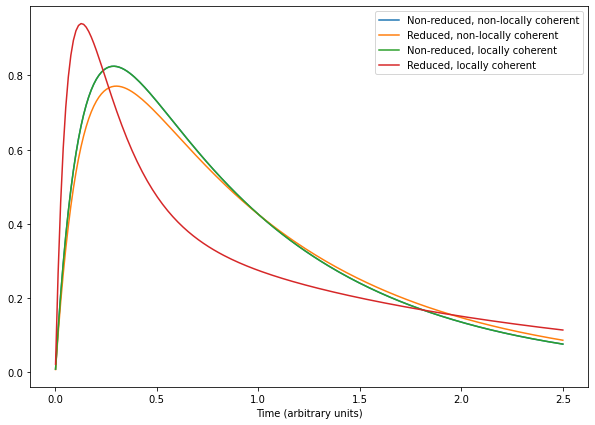

In [6]:
tvec = np.linspace(0.001, 2.5, 200)
plt.figure(figsize=(10, 7))
for i in range(len(conds)):
    p0 = np.zeros(conds[i][0].shape[0])
    p0[idxs[i]['partial']] = 1.0
    print(idxs[i], p0)
    plt.plot(tvec, [fp.etd(t, conds[i][0], conds[i][1], p0) for t in tvec], label=condnames[i])
plt.legend()
plt.xlabel('Time (arbitrary units)')
plt.show()

In [24]:
# Generating stochastic runs
stoch = []
for i in range(len(conds)):
     stoch.append(stochastic.rep_ssa(conds[i][-1], initidx=idxs[i]['partial'], n=2000))

Running 2000 stochastic simulations until absorbtion


100%|██████████| 2000/2000 [00:00<00:00, 7503.31it/s]


Running 2000 stochastic simulations until absorbtion


100%|██████████| 2000/2000 [00:00<00:00, 7824.57it/s]


Running 2000 stochastic simulations until absorbtion


100%|██████████| 2000/2000 [00:00<00:00, 7680.61it/s]


Running 2000 stochastic simulations until absorbtion


100%|██████████| 2000/2000 [00:00<00:00, 2755.28it/s]


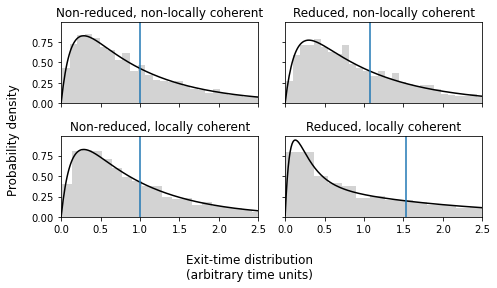

In [27]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True, squeeze=True, figsize=(7,4))
for i in range(len(conds)):
    p0 = np.zeros(conds[i][0].shape[0])
    p0[idxs[i]['partial']] = 1.0
    axs.flat[i].plot(tvec, [fp.etd(t, conds[i][0], conds[i][1], p0) for t in tvec], color='k')
    axs.flat[i].hist(stoch[i]['fpt'], density=True, color='lightgrey', bins=75)
    axs.flat[i].set_title(condnames[i])
    axs.flat[i].set_xlim(0, max(tvec))
    axs.flat[i].axvline(fp.meanvar(conds[i][0], p0)[0])
fig.supxlabel('Exit-time distribution\n(arbitrary time units)')
fig.supylabel('Probability density')
fig.tight_layout()
fig.savefig('lcetd.pdf')
plt.show()

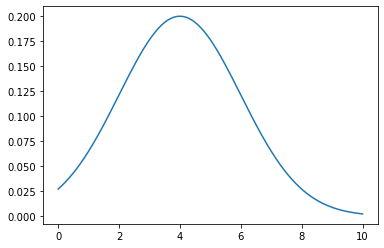

In [9]:
# In seconds instead of milliseconds
#data = np.array([0.468, 0.475, 0.397, 0.542])  # at verb
#data = np.array([0.471, 0.520, 0.451, 0.632])  # spillover
data = np.array([0.468, 0.422, 0.475, 0.449, 0.397, 0.400, 0.542, 0.506])  # at verb, exps. 1 & 2
tauvec = np.linspace(0.001, 10, 250)
prior = lambda tau: np.clip(norm(4, 2).pdf(tau), a_min=0.001, a_max=None)
#prior = lambda tau: np.clip(cauchy(5, 5).pdf(tau), a_min=0.001, a_max=None)
#prior = lambda tau: 0.1  # uniform distribution
priorvec = np.array([prior(tau) for tau in tauvec])
plt.plot(tauvec, priorvec)
plt.show()

In [10]:
# Defining the likelihood
# Very kludgy, hard-coded...
def lk(data, tau):
    llk = 0.0  # log likelihood
    # Assuming one data point per condition
    c = 0
    for i in range(len(data)):
        if i % 2 == 0 and i != 0 and len(data) != len(conds):
            c += 1
        p0 = np.zeros(conds[c][0].shape[0])
        p0[idxs[c]['partial']] = 1.0
        tauW, tauT, tauA = fp.rescale_matrices(conds[c][-1], tau)
        llk += np.log(fp.etd(data[i], tauT, tauA, p0))
    return np.exp(llk)

lk(data, 1.0)  # test

0.03929394414139707

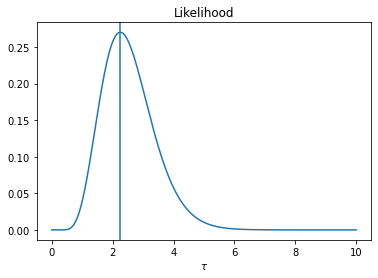

In [11]:
# Plotting the likelihood fn.
lkvec = np.array([lk(data, tau) for tau in tauvec])
tau_ml = tauvec[np.argmax(lkvec)]
plt.plot(tauvec, lkvec)
plt.axvline(tau_ml)
plt.title('Likelihood')
plt.xlabel(r'$\tau$')
plt.show()

In [12]:
posterior = bayes.quick_posterior(priorvec, lkvec)

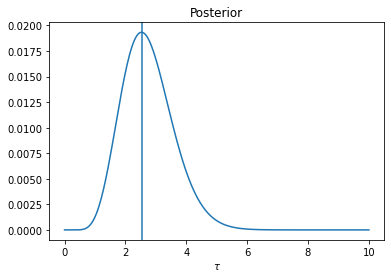

In [13]:
# Plotting the likelihood and posterior
tau_map = tauvec[np.argmax(posterior)]

plt.plot(tauvec, posterior)
plt.axvline(tau_map)
plt.title('Posterior')
plt.xlabel(r'$\tau$')
plt.show()

[0.445, 0.46199999999999997, 0.3985, 0.524]
Non-reduced, non-locally coherent
	True mean: 0.445
	MAP mean: 0.395, variance: 0.121
	ML mean: 0.444, variance: 0.154
Reduced, non-locally coherent
	True mean: 0.46199999999999997
	MAP mean: 0.424, variance: 0.142
	ML mean: 0.477, variance: 0.179
Non-reduced, locally coherent
	True mean: 0.3985
	MAP mean: 0.395, variance: 0.121
	ML mean: 0.444, variance: 0.154
Reduced, locally coherent
	True mean: 0.524
	MAP mean: 0.606, variance: 0.464
	ML mean: 0.682, variance: 0.587


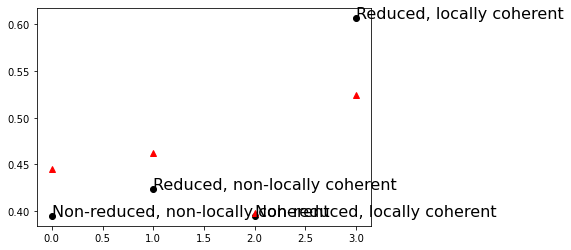

In [14]:
# Posterior checks w/ MAP
mndat = [np.mean(data[0:2]), np.mean(data[2:4]), np.mean(data[4:6]), np.mean(data[6:])]
print(mndat)
for i in range(len(condnames)):
    p0 = np.zeros(conds[i][0].shape[0])
    p0[idxs[i]['partial']] = 1.0
    print('{}'.format(condnames[i]))
    print('\tTrue mean: {}'.format(mndat[i]))
    _, fittedTmap, _ = fp.rescale_matrices(conds[i][-1], tau_map)
    _, fittedTml, _ = fp.rescale_matrices(conds[i][-1], tau_ml)
    mvmap = np.round(fp.meanvar(fittedTmap, p0), 3)
    mvml = np.round(fp.meanvar(fittedTml, p0), 3)
    print('\tMAP mean: {}, variance: {}'.format(*mvmap))
    print('\tML mean: {}, variance: {}'.format(*mvml))
    plt.plot(i, mvmap[0], 'ok')
    plt.plot(i, mndat[i], '^r')
    plt.annotate(condnames[i], xy=(i, mvmap[0]), fontsize=16)
plt.show()

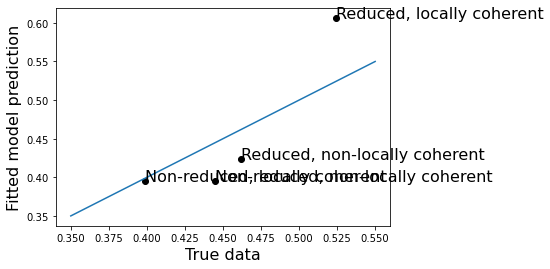

In [15]:
for i in range(len(condnames)):
    p0 = np.zeros(conds[i][0].shape[0])
    p0[idxs[i]['partial']] = 1.0
    _, fittedT, _ = fp.rescale_matrices(conds[i][-1], tau_map)
#    _, fittedT, _ = fp.rescale_matrices(conds[i][-1], tau_ml)
    fitted = np.round(fp.meanvar(fittedT, p0)[0], 3)
#    plt.plot(data[i], fitted, 'ko')
    plt.plot(mndat[i], fitted, 'ko')
    plt.annotate(condnames[i], xy=(mndat[i], fitted), fontsize=16)
plt.xlabel('True data', fontsize=16)
plt.ylabel('Fitted model prediction', fontsize=16)
#plt.plot([0.3, 0.7], [0.2, 0.6])  # spillover
plt.plot([0.35, 0.55], [0.35, 0.55])
plt.show()